# 城市路网分析与可达性评估 

In [9]:
# 环境初始化：导入所有必需的库
import osmnx as ox
import networkx as nx
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import folium
from shapely.geometry import MultiPoint
import warnings
warnings.filterwarnings('ignore')  # 忽略无关警告，保持输出整洁

# 设置中文字体支持（解决matplotlib中文显示问题）
plt.rcParams["font.family"] = ["SimSun"]  # 设置宋体
plt.rcParams['axes.unicode_minus'] = False
print("环境初始化完成，所有库已成功导入！")

环境初始化完成，所有库已成功导入！


## 一、路网数据下载与可视化（以纽约曼哈顿为例）
### 1.1 核心原理
- **OpenStreetMap（OSM）**：全球开放地理数据库，包含道路、建筑等丰富信息
- **OSMnx库**：封装OSM API调用，支持一行代码下载路网并转换为NetworkX图对象
- **图模型结构**：
  - 节点（Nodes）：代表交叉路口或道路端点，包含经纬度坐标
  - 边（Edges）：代表街道段，包含长度、名称、类型（如residential/highway）、单行道等属性

### 1.2 代码实现

正在从OpenStreetMap下载 'Manhattan, New York City' 的驾驶路网数据...
路网下载完成！图结构统计：
- 节点数量：4619
- 边数量：9900


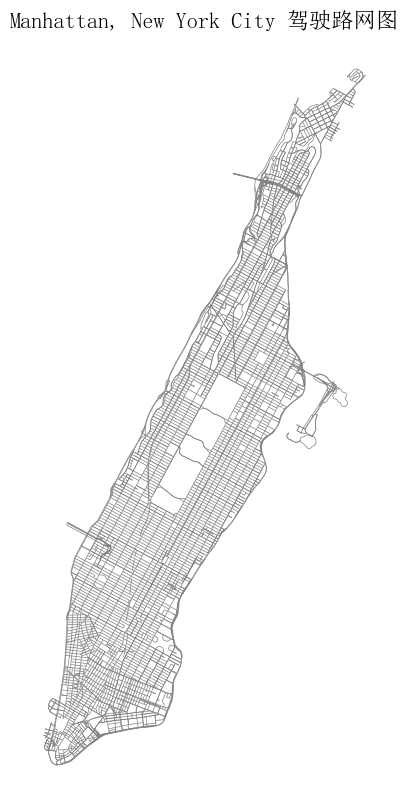

路网数据已保存为 manhattan_drive_network.graphml


In [10]:

# 1. 定义研究区域（可替换为任意城市/区域，如"Beijing, China"）
place_name = "Manhattan, New York City"
print(f"正在从OpenStreetMap下载 '{place_name}' 的驾驶路网数据...")

# 2. 下载驾驶路网（network_type可选：drive/walk/bike/all）
G = ox.graph_from_place(place_name, network_type='drive')
print(f"路网下载完成！图结构统计：")
print(f"- 节点数量：{G.number_of_nodes()}")
print(f"- 边数量：{G.number_of_edges()}")

# 3. 投影转换（将经纬度坐标系转为UTM坐标系，使长度单位为"米"）
G_proj = ox.project_graph(G)

# 4. 可视化路网
fig, ax = ox.plot_graph(
    G_proj,
    bgcolor="#FFFFFF",        # 背景色：白色
    edge_color="gray",       # 道路颜色：灰色
    node_size=0,             # 隐藏节点（避免画面杂乱）
    edge_linewidth=0.5,      # 道路线宽
    show=False,              # 不自动显示（后续统一控制）
    close=False              # 不自动关闭画布
)

# 添加标题与显示
ax.set_title(f'{place_name} 驾驶路网图', fontsize=16, pad=20)
plt.tight_layout()  # 自动调整布局
plt.show()

# 保存原始图数据（供后续分析使用）
ox.save_graphml(G_proj, "manhattan_drive_network.graphml")
print("路网数据已保存为 manhattan_drive_network.graphml")

## 二、最短路径分析（帝国大厦→时代广场）
### 2.1 核心原理
1. **地理编码**：通过`ox.geocode()`将地址字符串转为经纬度坐标
2. **节点吸附**：通过`ox.nearest_nodes()`将真实地址坐标匹配到路网节点（解决"地址不在节点上"问题）
3. **最短路径算法**：使用NetworkX的`nx.shortest_path()`，基于道路长度（`weight='length'`）计算物理距离最短路径

### 2.2 代码实现

起点坐标（Empire State Building, New York, NY）：(40.7484421, -73.9856589)
终点坐标（Times Square, New York, NY）：(40.7572614, -73.9858998)
起点匹配节点ID：42446701
终点匹配节点ID：42439984
最短路径包含 16 个节点
最短路径总长度：1.63 千米


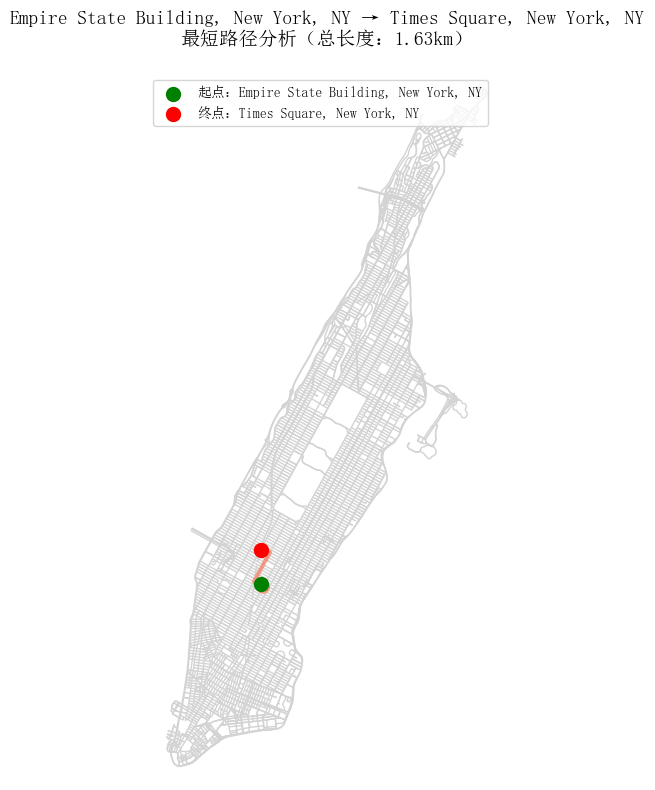

最短路径数据已保存为 shortest_path_nodes.txt


In [12]:
# 1. 定义起止点地址（可替换为任意地址）
origin_address = "Empire State Building, New York, NY"  # 起点：帝国大厦
dest_address = "Times Square, New York, NY"              # 终点：时代广场

# 2. 地理编码：地址→经纬度
origin_point = ox.geocode(origin_address)  # (纬度, 经度)
dest_point = ox.geocode(dest_address)
print(f"起点坐标（{origin_address}）：{origin_point}")
print(f"终点坐标（{dest_address}）：{dest_point}")

# 3. 节点吸附：经纬度→路网节点ID
# 注意：G_proj的节点属性中，x=经度，y=纬度，需对应传入
origin_node = ox.nearest_nodes(G, origin_point[1], origin_point[0])
dest_node = ox.nearest_nodes(G, dest_point[1], dest_point[0])
print(f"起点匹配节点ID：{origin_node}")
print(f"终点匹配节点ID：{dest_node}")

# 4. 计算最短路径（基于道路长度）
shortest_path = nx.shortest_path(G_proj, origin_node, dest_node, weight='length')
print(f"最短路径包含 {len(shortest_path)} 个节点")

# 5. 计算路径总长度（单位：米→千米）
path_length = nx.shortest_path_length(G_proj, origin_node, dest_node, weight='length') / 1000
print(f"最短路径总长度：{path_length:.2f} 千米")

# 6. 可视化最短路径
fig, ax = ox.plot_graph_route(
    G,
    shortest_path,
    route_color="#FF5733",    # 路径颜色：橙色
    route_linewidth=3,        # 路径线宽
    bgcolor="#FFFFFF",
    edge_color="lightgray",   # 非路径道路：浅灰色（突出路径）
    node_size=0,
    show=False,
    close=False
)

# 添加起止点标记与标题
ax.scatter(origin_point[1], origin_point[0], c='green', s=100, label=f'起点：{origin_address}', zorder=5)
ax.scatter(dest_point[1], dest_point[0], c='red', s=100, label=f'终点：{dest_address}', zorder=5)
ax.set_title(f'{origin_address} → {dest_address}\n最短路径分析（总长度：{path_length:.2f}km）', fontsize=14, pad=20)
ax.legend(loc='upper right', fontsize=10)
plt.tight_layout()
plt.show()

# 保存路径数据
with open("shortest_path_nodes.txt", "w") as f:
    f.write(f"起止点：{origin_address} → {dest_address}\n")
    f.write(f"总长度：{path_length:.2f}km\n")
    f.write(f"路径节点ID列表：{shortest_path}")
print("最短路径数据已保存为 shortest_path_nodes.txt")

## 三、服务区（等时圈）与可达性分析（以纽约大学为中心）
### 3.1 核心原理
1. **步行网络构建**：下载步行路网并添加`travel_time`属性（基于默认步行速度：5km/h）
2. **等时圈生成**：通过`nx.ego_graph()`以"旅行时间"为半径，筛选可达节点，再通过`convex_hull`生成最小包围多边形
3. **POI空间查询**：通过OSM标签（如`{"amenity": "hospital"}`）下载兴趣点，再通过`gpd.sjoin()`筛选等时圈内的POI
4. **交互式可视化**：使用Folium生成HTML地图，支持缩放、点击查看POI信息

### 3.2 代码实现
#### 3.2.1 步行路网与等时圈生成

正在下载曼哈顿步行路网...
步行路网准备完成！
- 步行路网节点数：37409
- 步行路网边数：119926
分析中心：New York University, New York, NY（坐标：(40.7292053, -73.9950148)，节点ID：8309478899）
成功生成 15 分钟步行等时圈！


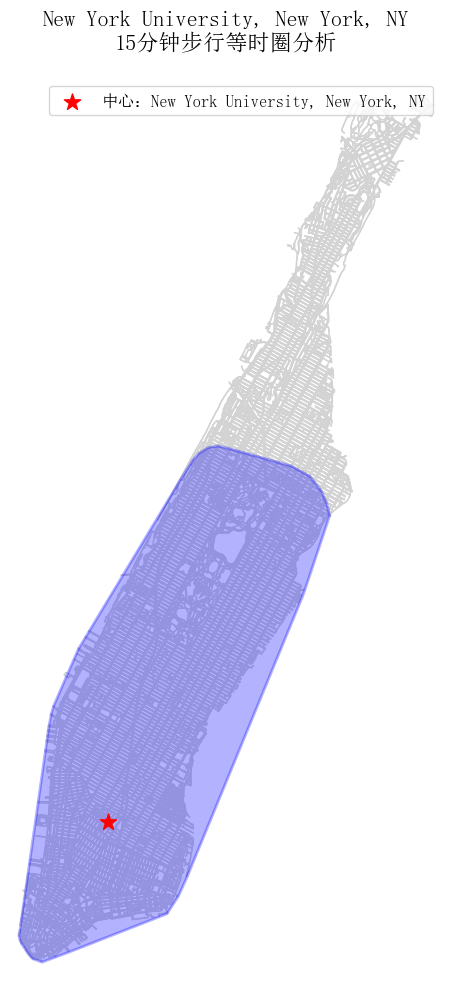

等时圈数据已保存为 isochrone_15min.geojson


In [ ]:
# 1. 下载步行路网（network_type='walk'）
print("正在下载曼哈顿步行路网...")
G_walk = ox.graph_from_place(place_name, network_type='walk')

# 2. 添加边属性：速度（默认）与旅行时间（单位：秒）
G_walk = ox.add_edge_speeds(G_walk)  # 步行默认速度：5 km/h
G_walk = ox.add_edge_travel_times(G_walk)  # 旅行时间 = 长度 / 速度
print("步行路网准备完成！")
print(f"- 步行路网节点数：{G_walk.number_of_nodes()}")
print(f"- 步行路网边数：{G_walk.number_of_edges()}")

# 3. 定义分析参数
center_address = "New York University, New York, NY"  # 中心地址：纽约大学
travel_time_minutes = 15  # 可达时间：15分钟
travel_time_seconds = travel_time_minutes * 60  # 转换为秒

# 4. 中心地址→经纬度→路网节点
center_point = ox.geocode(center_address)
center_node = ox.nearest_nodes(G_walk, center_point[1], center_point[0])
print(f"分析中心：{center_address}（坐标：{center_point}，节点ID：{center_node}）")

# 5. 生成等时圈（15分钟步行可达节点）
# ego_graph：以center_node为中心，travel_time_seconds为半径筛选可达节点
subgraph = nx.ego_graph(
    G_walk,
    center_node,
    radius=travel_time_seconds,
    distance='travel_time'  # 以旅行时间为"距离"度量
)

# 6. 从可达节点生成等时圈多边形
# 提取节点经纬度
node_points = [
    (data['x'], data['y'])  # (经度, 纬度)
    for node, data in subgraph.nodes(data=True)
    if 'x' in data and 'y' in data  # 确保节点有坐标属性
]

# 生成最小凸多边形（convex_hull）
# 稳健性保证
if len(node_points) >= 3:  # 至少3个点才能构成多边形
    isochrone_polygon = MultiPoint(node_points).convex_hull
    # 转换为GeoDataFrame（便于后续空间分析）
    isochrone_gdf = gpd.GeoDataFrame(
        [{'geometry': isochrone_polygon, 'travel_time_min': travel_time_minutes}],
        crs=G_walk.graph['crs']  # 继承路网坐标系（WGS84）
    )
    print(f"成功生成 {travel_time_minutes} 分钟步行等时圈！")
else:
    raise ValueError("可达节点数量不足，无法生成等时圈，请检查路网数据或调整时间参数")

# 7. 可视化等时圈（静态图）
fig, ax = plt.subplots(figsize=(10, 10))
# 绘制步行路网（浅灰色）
ox.plot_graph(G_walk, ax=ax, bgcolor="#FFFFFF", edge_color="lightgray", node_size=0, show=False, close=False)
# 绘制等时圈（蓝色半透明）
isochrone_gdf.plot(ax=ax, color="blue", alpha=0.3, edgecolor="blue", linewidth=2, label=f'{travel_time_minutes}分钟步行圈')
# 绘制中心点（红色）
ax.scatter(center_point[1], center_point[0], c='red', s=150, marker='*', label=f'中心：{center_address}', zorder=5)

# 添加标题与图例
ax.set_title(f'{center_address}\n{travel_time_minutes}分钟步行等时圈分析', fontsize=16, pad=20)
ax.legend(loc='upper right', fontsize=12)
plt.tight_layout()
plt.show()

# 保存等时圈数据
isochrone_gdf.to_file("isochrone_15min.geojson", driver="GeoJSON")
print("等时圈数据已保存为 isochrone_15min.geojson")

#### 3.2.2 POI（医院）可达性分析与交互式地图

In [ ]:
# 1. 下载研究区域内的POI（医院）
# OSM标签说明：amenity=hospital 表示医疗设施（医院）
tags = {"amenity": "hospital"}
print(f"正在下载 {place_name} 区域内的医院数据...")
hospitals = ox.features_from_place(place_name, tags)

# 数据预处理：只保留点类型POI（排除面类型的医院建筑）
hospitals = hospitals[hospitals.geometry.geom_type == 'Point'].copy()
print(f"共找到 {len(hospitals)} 家医院（点类型POI）")

# 2. 空间连接：筛选等时圈内的医院
# 确保坐标系一致
hospitals = hospitals.to_crs(isochrone_gdf.crs)
# sjoin：空间连接，predicate='within' 表示"在...内部"
hospitals_in = gpd.sjoin(hospitals, isochrone_gdf, predicate='within', how='inner')
hospitals_out = hospitals[~hospitals.index.isin(hospitals_in.index)]  # 等时圈外的医院

print(f"可达性统计：")
print(f"- {travel_time_minutes}分钟步行圈内：{len(hospitals_in)} 家医院")
print(f"- {travel_time_minutes}分钟步行圈外：{len(hospitals_out)} 家医院")

# 3. 生成交互式地图（Folium）
# 初始化地图（中心为分析点，缩放级别14）
m = folium.Map(
    location=center_point,  # (纬度, 经度)
    zoom_start=14,
    tiles="Cartodb positron"  # 浅色底图（突出标注）
)

# 3.1 添加等时圈
folium.GeoJson(
    isochrone_gdf,
    name=f'{travel_time_minutes}分钟步行圈',
    style_function=lambda x: {
        'fillColor': 'blue',
        'color': 'blue',
        'weight': 2,
        'fillOpacity': 0.2
    },
    tooltip=f'{travel_time_minutes}分钟步行可达区域'
).add_to(m)

# 3.2 添加圈内医院（绿色标记）
for idx, row in hospitals_in.iterrows():
    # 获取医院名称（若没有则显示"Unnamed Hospital"）
    hospital_name = row.get('name', 'Unnamed Hospital')
    # 添加标记
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],  # (纬度, 经度)
        popup=f"<b>医院名称</b>：{hospital_name}<br><b>位置</b>：({row.geometry.y:.4f}, {row.geometry.x:.4f})",
        icon=folium.Icon(color='green', icon='hospital', prefix='fa'),  # Font Awesome图标
        tooltip=hospital_name
    ).add_to(m)

# 3.3 添加圈外医院（红色标记）
for idx, row in hospitals_out.iterrows():
    hospital_name = row.get('name', 'Unnamed Hospital')
    folium.Marker(
        location=[row.geometry.y, row.geometry.x],
        popup=f"<b>医院名称</b>：{hospital_name}<br><b>位置</b>：({row.geometry.y:.4f}, {row.geometry.x:.4f})",
        icon=folium.Icon(color='red', icon='hospital', prefix='fa'),
        tooltip=hospital_name
    ).add_to(m)

# 3.4 添加分析中心（蓝色星标）
folium.Marker(
    location=center_point,
    popup=f"<b>分析中心</b>：{center_address}<br><b>可达时间</b>：{travel_time_minutes}分钟（步行）",
    icon=folium.Icon(color='blue', icon='star', prefix='fa'),
    tooltip="分析中心"
).add_to(m)

# 3.5 添加图层控制器（支持显示/隐藏图层）
folium.LayerControl(collapsed=False).add_to(m)

# 4. 保存交互式地图
map_filename = "manhattan_hospital_accessibility.html"
m.save(map_filename)
print(f"交互式可达性地图已保存为：{map_filename}")

# 5. 输出POI统计结果到文件
with open("hospital_accessibility_stats.txt", "w", encoding='utf-8') as f:
    f.write(f"=== {center_address} {travel_time_minutes}分钟步行可达性分析报告 ===\n")
    f.write(f"分析时间：{pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    f.write(f"研究区域：{place_name}\n\n")
    f.write(f"1. 医院总数：{len(hospitals)} 家\n")
    f.write(f"2. 可达医院数：{len(hospitals_in)} 家\n")
    f.write(f"3. 不可达医院数：{len(hospitals_out)} 家\n")
    f.write(f"4. 可达率：{len(hospitals_in)/len(hospitals)*100:.1f}%\n\n")
    f.write("=== 可达医院列表 ===\n")
    for idx, row in hospitals_in.iterrows():
        name = row.get('name', 'Unnamed Hospital')
        f.write(f"- {name}（坐标：{row.geometry.y:.4f}, {row.geometry.x:.4f}）\n")

print("POI统计结果已保存为：hospital_accessibility_stats.txt")

正在下载 Manhattan, New York City 区域内的医院数据...
共找到 16 家医院（点类型POI）
可达性统计：
- 15分钟步行圈内：13 家医院
- 15分钟步行圈外：3 家医院
交互式可达性地图已保存为：manhattan_hospital_accessibility.html
POI统计结果已保存为：hospital_accessibility_stats.txt


## 四、扩展分析建议（可选）
1. **更换研究区域**：将`place_name`改为其他城市（如`"Beijing, China"`、`"Shanghai, China"`），需注意：
   - 国内区域可能需要更精确的边界（如`"海淀区, 北京市, China"`）
   - 部分区域OSM数据可能不完整，可调整`network_type`或`ox.graph_from_bbox()`（基于经纬度范围下载）

2. **更换POI类型**：修改`tags`参数，支持的常见POI类型：
   - 学校：`{"amenity": "school"}`
   - 咖啡馆：`{"amenity": "cafe"}`
   - 超市：`{"shop": "supermarket"}`
   - 地铁站：`{"public_transport": "station", "station": "subway"}`

3. **多时间维度分析**：生成多个时间的等时圈（如5/10/15/20分钟），对比可达范围变化：

In [ ]:
travel_times = [5, 10, 15, 20]  # 多时间维度
isochrones = []
for t in travel_times:
    subgraph = nx.ego_graph(G_walk, center_node, radius=t*60, distance='travel_time')
    node_points = [(d['x'], d['y']) for _, d in subgraph.nodes(data=True) if 'x' in d]
    if len(node_points)>=3:
        poly = MultiPoint(node_points).convex_hull
        isochrones.append(gpd.GeoDataFrame([{'travel_time':t, 'geometry':poly}], crs=G_walk.graph['crs']))
isochrones_gdf = pd.concat(isochrones, ignore_index=True)


4. **多交通方式对比**：分别下载`drive`/`walk`/`bike`路网，对比同一地点不同交通方式的可达性差异


## 五、文件输出汇总
运行完成后，将生成以下文件（需全部提交）：
1. 代码文件：`city_road_network_analysis.ipynb`（本Notebook）
2. 路网数据：`manhattan_drive_network.graphml`、`manhattan_walk_network.graphml`（需手动保存）
3. 等时圈数据：`isochrone_15min.geojson`
4. 最短路径数据：`shortest_path_nodes.txt`
5. 交互式地图：`manhattan_hospital_accessibility.html`
6. 统计报告：`hospital_accessibility_stats.txt`
7. 截图：所有静态图的截图（建议保存为PNG格式，插入分析报告）

## 六、常见问题解决
1. **OSM数据下载失败**：
   - 检查网络连接（需访问国际网络）
   - 更换`place_name`为更精确的区域（如添加城市/国家）
   - 使用`ox.graph_from_bbox(north, south, east, west)`基于经纬度范围下载

2. **等时圈无法生成**：
   - 检查`node_points`数量（需≥3个点）
   - 增大`travel_time_minutes`（如从15分钟改为30分钟）
   - 更换`network_type`为`'walk'`（步行路网节点更密集）

3. **中文显示乱码**：
   - 确保已执行`plt.rcParams`中文字体设置
   - 保存文件时使用`encoding='utf-8'`

4. **Folium地图无法打开**：
   - 直接用浏览器打开HTML文件（无需服务器）
   - 检查`center_point`是否为`(纬度, 经度)`格式（Folium要求）